In [1]:
import torch
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on the GPU.')
else:
    device = torch.device('cpu')
    print('Running on the CPU.')

Running on the GPU.


In [2]:
import os
import json

def is_valid_segment(segment):
    return len(segment['speakers']) == 1 \
            and len(segment['ivectors']) == 1 \
            and len(segment['xvectors']) == 1 \
            # and segment['speakers'][0]['speaker_id'] in ['A', 'B']

mode = 'ivectors'

def to_device(segment):
    segment[mode][0]['value'] = torch.Tensor(segment[mode][0]['value']).to(device, non_blocking = True).float()
    return segment

directory = 'exp/json'
filenames = [filename for filename in os.listdir(directory) if os.path.isfile(os.path.join(directory, filename))]

recordings_segments = {}
recordings_length = len(filenames)
recordings_count = 0
for filename in filenames:
    recording_id = filename.split('.')[0]
    filepath = os.path.join(directory, filename)
    file = open(filepath, 'r')
    recordings_segments[recording_id] = [json.loads(line) for line in file.readlines()]
    file.close()
    recordings_segments[recording_id] = list(filter(is_valid_segment, recordings_segments[recording_id]))
    recordings_segments[recording_id] = [to_device(segment) for segment in recordings_segments[recording_id]]
    recordings_count += 1
    print('Loading data: ' + str(recordings_count) + '/' + str(recordings_length), end = '\r')

In [3]:
from torch.utils.data import Dataset
from functools import reduce
import numpy as np
import itertools

models_generation_length = 3 # <------------------------- IMPORTANTE
models_container_length = 3  # <------------------------- IMPORTANTE

def speakers_get_indexes(accumulator, speaker_tuple):
    speaker_id, index = speaker_tuple
    if speaker_id in accumulator:
        accumulator[speaker_id].append(index)
    else:
        accumulator[speaker_id] = [index]
    return accumulator

class Recordings_dataset(Dataset):
    def __init__(self, recordings_segments, recordings_ids, mode = 'ivectors'):
        self.recordings_ids = recordings_ids if isinstance(recordings_ids, list) else [recordings_ids]
        self.recordings_segments = {}
        for recording_id in self.recordings_ids:
            self.recordings_segments[recording_id] = recordings_segments[recording_id]
        self.mode = mode
        self.models_generation_length = models_generation_length
        self.models_container_length = models_container_length
        self.recordings_data = {}
        self.recordings_map = []
        self.recordings_length = 0
        for recording_id in self.recordings_ids:
            self.recordings_data[recording_id] = {}
            recording_segments = self.recordings_segments[recording_id]
            recording_data = self.recordings_data[recording_id]
            recording_data['speakers_indexes'] = [(segment['speakers'][0]['speaker_id'], index) for index, segment in enumerate(recording_segments)]
            recording_data['speakers_indexes'] = reduce(speakers_get_indexes, recording_data['speakers_indexes'], {})
            recording_data['speakers_models'] = {}
            for speaker_id in recording_data['speakers_indexes']:
                speaker_indexes = recording_data['speakers_indexes'][speaker_id]
                speaker_vectors = [recording_segments[index][self.mode][0]['value'] for index in speaker_indexes[:self.models_generation_length]]
                recording_data['speakers_models'][speaker_id] = [torch.sum(torch.stack(speaker_vectors, 0), 0) / len(speaker_vectors)]
            #recording_data['permutations'] = list(itertools.permutations(list(recording_data['speakers_models'].keys()) \
            #+ ['0' for i in range(self.models_container_length)], self.models_container_length))
            recording_data['permutations'] = list(itertools.permutations(list(recording_data['speakers_models'].keys()), self.models_container_length))
            recording_data['permutations'] = list(set(recording_data['permutations']))
            recording_data['permutations'].sort()
            recording_data['permutations_map'] = []
            recording_data['permutations_length'] = 0
            for index, permutation in enumerate(recording_data['permutations']):
                speakers_models_length = int(np.prod([len(recording_data['speakers_models'][speaker_id]) for speaker_id in permutation if speaker_id != '0']))
                recording_data['permutations_map'].append((recording_data['permutations_length'], recording_data['permutations_length'] + speakers_models_length - 1, index))
                recording_data['permutations_length'] += speakers_models_length
            recording_data['length'] = len(recording_segments) * recording_data['permutations_length']
            self.recordings_map.append((self.recordings_length, self.recordings_length + recording_data['length'] - 1, recording_id))
            self.recordings_length += recording_data['length']
    def __len__(self):
        return self.recordings_length
    def __getitem__(self, idx):
        recording_tuple = list(filter(lambda recording_tuple: recording_tuple[0] <= idx and idx <= recording_tuple[1], self.recordings_map))[0]
        recording_idx = idx - recording_tuple[0]
        recording_id = recording_tuple[2]
        recording_data = self.recordings_data[recording_id]
        
        segment_id, segment_idx = divmod(recording_idx, recording_data['permutations_length'])
        segment = self.recordings_segments[recording_id][segment_id]
        target_id = segment['speakers'][0]['speaker_id']
        vector = segment[self.mode][0]['value']
        
        permutation_tuple = list(filter(lambda permutation_tuple: permutation_tuple[0] <= segment_idx and segment_idx <= permutation_tuple[1], recording_data['permutations_map']))[0]
        permutation_id = permutation_tuple[2]
        permutation = recording_data['permutations'][permutation_id]
        
        models_container = [recording_data['speakers_models'][speaker_id][0] if speaker_id != '0' else torch.zeros(len(vector)).to(device, non_blocking = True).float() for speaker_id in permutation]
        models_weigths = torch.Tensor([len(recording_data['speakers_indexes'][speaker_id]) if speaker_id != '0' else 1 for speaker_id in permutation]).to(device, non_blocking = True).float()
        models_weigths_sum = torch.sum(models_weigths)
        models_weigths = torch.ones(len(models_weigths)).to(device, non_blocking = True).float() - models_weigths / models_weigths_sum
        
        x = [vector] + models_container
        y = torch.Tensor([speaker_id == target_id for speaker_id in permutation]).to(device, non_blocking = True).float()
        z = models_weigths
        
        return x, y, z

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(128 * (models_container_length + 1), 32),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(32, models_container_length),
            nn.Sigmoid()
        )
        
    def forward(self, input):
        x = torch.cat(input, 1)
        x = self.fc1(x)
        return x

In [5]:
import random
recordings_ids = [filename.split('.')[0] for filename in filenames][:100]
random.shuffle(recordings_ids)
train_length = int(len(recordings_ids) * 0.7)
test_length = len(recordings_ids) - train_length
validation_length = int((train_length * 0.3))
train_length = train_length - validation_length
train_ids = recordings_ids[:train_length]
validation_ids = recordings_ids[train_length:train_length + validation_length]
test_ids = recordings_ids[train_length + validation_length:]

In [6]:
from torch.utils.data import DataLoader

train_dataset = Recordings_dataset(recordings_segments, train_ids)
validation_dataset = Recordings_dataset(recordings_segments, validation_ids)

train_dataloader = DataLoader(train_dataset, batch_size = 100, shuffle = True)
validation_dataloader = DataLoader(validation_dataset, batch_size = 100)

<IPython.core.display.Javascript object>


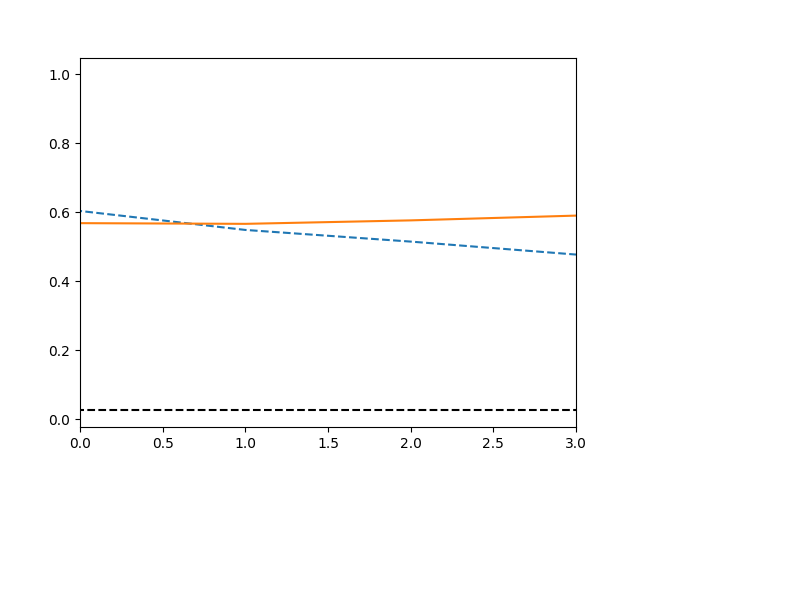

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.


KeyboardInterrupt: 

In [9]:
%matplotlib notebook
import torch.optim as optim
import matplotlib.pyplot as plt

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr = 0.0001)

epochs = 1000
validation_threshold = 0.025

plt_count = -1
plt_thr = ([plt_count], [validation_threshold])
plt_loss = ([plt_count], [1])
plt_valid = ([plt_count], [1])
fig = plt.figure()
ax = fig.add_subplot()
line0, = ax.plot(plt_thr[0], plt_thr[1], 'k--')  # Threshold line
line1, = ax.plot(plt_loss[0], plt_loss[1], '--') # Training loss
line2, = ax.plot(plt_valid[0], plt_valid[1])     # Validation loss
ax.set_xlim(-1, 0)
fig.canvas.draw()
fig.canvas.flush_events()

for epoch in range(epochs):
    train_losses = []
    for input, target, weigth in train_dataloader:
        criterion = nn.BCELoss()
        net.zero_grad()
        output = net(input)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.data)
        print('train: ' + str(len(train_losses)) + '/' + str(len(train_dataloader)) + '     ', end = '\r')
    train_loss = np.sum(train_losses) / len(train_losses)
        
        
    validation_losses = []
    with torch.no_grad():
        for input, target, weigth in validation_dataloader:
            #input = [tensor.to(device, non_blocking = True).float() for tensor in input]
            #target = target.to(device, non_blocking = True).float()
            #weigth = weigth.to(device, non_blocking = True).float()
            
            criterion = nn.BCELoss()
            output = net(input)
            loss = criterion(output, target)
            validation_losses.append(loss.data)
            print('test: ' + str(len(validation_losses)) + '/' + str(len(validation_dataloader)) + '     ', end = '\r')
    validation_loss = np.sum(validation_losses) / len(validation_losses)
            
    plt_count += 1
    plt_thr[0].append(plt_count)
    plt_thr[1].append(validation_threshold)
    plt_loss[0].append(plt_count)
    plt_loss[1].append(train_loss)
    plt_valid[0].append(plt_count)
    plt_valid[1].append(validation_loss)
    line0.set_xdata(plt_thr[0])
    line0.set_ydata(plt_thr[1])
    line1.set_xdata(plt_loss[0])
    line1.set_ydata(plt_loss[1])
    line2.set_xdata(plt_valid[0])
    line2.set_ydata(plt_valid[1])
    ax.set_xlim(0, plt_count)
    fig.canvas.draw()
    fig.canvas.flush_events()
    
    
    if validation_loss <= validation_threshold:
        print('Done training.')
        break